<a href="https://colab.research.google.com/github/sukcsie/DataScience-and-MachineLearning/blob/main/SentimentClassification_CovNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objective:** Classify sentiments from social media reviews.

**Dataset:** Used [Sentiment labelled sentences dataset](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences) from UCI machine learning repository.

**Analysis:** Used COnvolutional NN for classifying the sentences based on their polarity/ sentences. Used Glove embeddings. [TODO: other models]

In [1]:
import pandas as pd
import numpy as np


In [2]:
# load dataset
# uploading a data file in colab
from google.colab import files # only needed if you use colab
files.upload() # only needed if you use colab

df = pd.read_csv('yelp_labelled.txt', names=['sentence', 'label'], sep='\t')

Saving yelp_labelled.txt to yelp_labelled (2).txt


In [3]:
df.head()

,sentence,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [4]:
# utility function for plotting
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [5]:
# function for creating model
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dropout(.25))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dropout(.25))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [6]:
# Defining parameters for Randomized Grid Search
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [7]:
# checking if the dataset is balanced or not
df['label'].value_counts()

1    500
0    500
Name: label, dtype: int64

In [8]:
'''
# creating the model
# just for testing the code with one setting
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(.25))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
'''

"\n# creating the model\n# just for testing the code with one setting\nfrom keras.models import Sequential\nfrom keras import layers\n\nembedding_dim = 50\n\nmodel = Sequential()\nmodel.add(layers.Embedding(input_dim=vocab_size, \n                           output_dim=embedding_dim, \n                           input_length=maxlen))\nmodel.add(layers.GlobalMaxPool1D())\nmodel.add(layers.Dense(10, activation='relu'))\nmodel.add(layers.Dropout(.25))\nmodel.add(layers.Dense(1, activation='sigmoid'))\nmodel.compile(optimizer='adam',\n              loss='binary_crossentropy',\n              metrics=['accuracy'])\nmodel.summary()\n"

In [9]:
# train-test split using sklearn
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from keras import layers


# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100

sentences = df['sentence'].values
y = df['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(
                                                sentences, y,  
                                                test_size=0.10,  
                                                random_state=1000)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

# Adding 1 because of  reserved 0 index
vocab_size = len(tokenizer.word_index) + 1                          

# padded sequences
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [10]:


# Running the model with different hyperparameters
model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(X_train, y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.5min finished


In [11]:
# printing grid variables
print(grid_result.best_params_)

{'vocab_size': 5000, 'num_filters': 32, 'maxlen': 100, 'kernel_size': 5, 'embedding_dim': 50}


In [16]:
# creating model with best parameters from grid search
# using it to fit the data
# and plot the history

## Capture the best params
params = grid_result.best_params_

## create the model with the best params found
best_model = create_model(params['num_filters'], 
                          params['kernel_size'], 
                          params['vocab_size'], 
                          params['embedding_dim'], 
                          params['maxlen'])

history = best_model.fit(X_train, y_train,
                    epochs=15,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

loss, accuracy = best_model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 1.0000
Testing Accuracy:  0.8200


In [17]:
# checking the history keys before using it for plot function
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


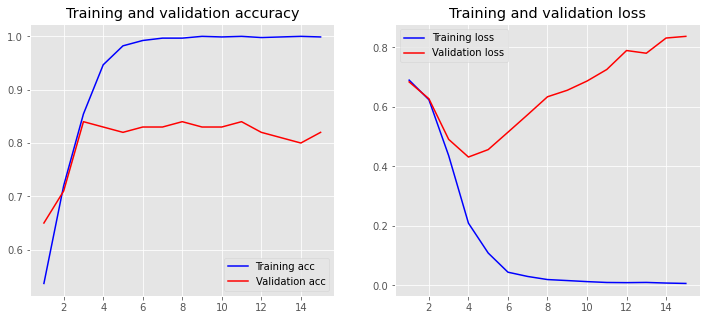

In [18]:
plot_history(history)

In [19]:

# Evaluate testing set
test_accuracy = best_model.evaluate(X_test, y_test)
print(test_accuracy)

4/4 [==============================] - 0s 4ms/step - loss: 0.8369 - accuracy: 0.8200
[0.8368925452232361, 0.8199999928474426]
